In [38]:
import os
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from src.dataimport import list_files_with_extension_directory, load_text

# Loading Files

In [39]:
TXT_FILES_PATH = 'data/original/brat-project-final/'
JSON_FILES_PATH = 'data/transformed/'

txt_files_directory_list = list_files_with_extension_directory(TXT_FILES_PATH, '.txt')

json_files_directory_list = list_files_with_extension_directory(JSON_FILES_PATH, '.json')

In [40]:
df = pd.DataFrame()
df['txt_path'] = txt_files_directory_list
df['json_path'] = json_files_directory_list
df['txt_file'] = df['txt_path'].apply(lambda x: os.path.basename(x))
df['json_file'] = df['json_path'].apply(lambda x: os.path.basename(x))
df['txt'] = df['txt_path'].apply(load_text)
df['json'] = df['json_path'].apply(load_text)

print(df.shape)
df.head()

(402, 6)


,txt_path,json_path,txt_file,json_file,txt,json
0,data/original/brat-project-final/essay001.txt,data/transformed/essay001.json,essay001.txt,essay001.json,Should students be taught to compete or to coo...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
1,data/original/brat-project-final/essay002.txt,data/transformed/essay002.json,essay002.txt,essay002.json,More people are migrating to other countries t...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
2,data/original/brat-project-final/essay003.txt,data/transformed/essay003.json,essay003.txt,essay003.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
3,data/original/brat-project-final/essay004.txt,data/transformed/essay004.json,essay004.txt,essay004.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
4,data/original/brat-project-final/essay005.txt,data/transformed/essay005.json,essay005.txt,essay005.json,Living and studying overseas\n\nIt is every st...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."


# Train-Test Split

In [41]:
# Split the dataframe into training and test sets
train_df, test_df = train_test_split(df, train_size=40, random_state=42)

# Display the first few rows of the training and test sets
print(f"Training DataFrame: {train_df.shape}")
print(f"\nTest DataFrame: {test_df.shape}")

Training DataFrame: (40, 6)

Test DataFrame: (362, 6)


In [42]:
train_df = train_df.sort_values(by='txt_file')
train_df.head()

,txt_path,json_path,txt_file,json_file,txt,json
20,data/original/brat-project-final/essay021.txt,data/transformed/essay021.json,essay021.txt,essay021.json,Advertisements affects on consumer goods\n\nEv...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
21,data/original/brat-project-final/essay022.txt,data/transformed/essay022.json,essay022.txt,essay022.json,Young people should go to university or not\n\...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
48,data/original/brat-project-final/essay049.txt,data/transformed/essay049.json,essay049.txt,essay049.json,Do modern communication technologies benefit a...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
50,data/original/brat-project-final/essay051.txt,data/transformed/essay051.json,essay051.txt,essay051.json,Universities should give money to sport activi...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
54,data/original/brat-project-final/essay055.txt,data/transformed/essay055.json,essay055.txt,essay055.json,Should teenagers learn all school subjects/foc...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."


In [43]:
test_df = test_df.sort_values(by='txt_file')
test_df.head()

,txt_path,json_path,txt_file,json_file,txt,json
0,data/original/brat-project-final/essay001.txt,data/transformed/essay001.json,essay001.txt,essay001.json,Should students be taught to compete or to coo...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
1,data/original/brat-project-final/essay002.txt,data/transformed/essay002.json,essay002.txt,essay002.json,More people are migrating to other countries t...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
2,data/original/brat-project-final/essay003.txt,data/transformed/essay003.json,essay003.txt,essay003.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
3,data/original/brat-project-final/essay004.txt,data/transformed/essay004.json,essay004.txt,essay004.json,International tourism is now more common than ...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."
4,data/original/brat-project-final/essay005.txt,data/transformed/essay005.json,essay005.txt,essay005.json,Living and studying overseas\n\nIt is every st...,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1..."


# Daten aufbereiten

## Grundwahrheit
aus Testdatensatz

In [44]:
def replace_ids_with_sentences(data):
    """
    Ersetzt die IDs in den argumentativen Beziehungen durch die entsprechenden Texte aus den Major Claims, Claims und Premises. 
    Zur Anwendung auf einen Pandas Dataframe.
    Args:
        data (dict): Dictionary aus den JSON-Dateien mit den Argumentationskomponenten und -beziehungen
    Returns:
        list: Liste von Dictionaries mit den Argumentativen Beziehungen, wobei die IDs durch die entsprechenden Texte ersetzt wurden
    """
    # Create dictionaries to map IDs to sentences
    major_claims = {mc['ID']: mc['Text'] for mc in data['MajorClaims']}
    claims = {c['ID']: c['Text'] for c in data['Claims']}
    premises = {p['ID']: p['Text'] for p in data['Premises']}

    transformed_relations = []
    # Aus den Beziehungen die Origin und Target IDs entnehmen 
    for relation in data['ArgumentativeRelations']:
        origin_id = relation['Origin']
        target_id = relation['Target']
        # Wenn die ID in den Major Claims (Dict) enthalten ist, dann den Text ausgeben
        if origin_id in major_claims:
            origin_text = major_claims[origin_id]
        # Wenn die ID in den Claims (Dict) enthalten ist, dann den Text ausgeben
        elif origin_id in claims:
            origin_text = claims[origin_id]
        # Wenn die ID in den Premises (Dict) enthalten ist, dann den Text ausgeben
        elif origin_id in premises:
            origin_text = premises[origin_id]
        # Wenn die ID nicht in den Major Claims, Claims oder Premises enthalten ist, dann die ID ausgeben
        else:
            origin_text = origin_id

        # Wie zuvor, nur mit der TargetID
        if target_id in major_claims:
            target_text = major_claims[target_id]
        elif target_id in claims:
            target_text = claims[target_id]
        elif target_id in premises:
            target_text = premises[target_id]
        else:
            target_text = target_id # Notwendig, da bei Beziehungen zu MajorClaims nicht definiert wird um welchen MajorClaim es sich handelt. 

        # Die Beziehungen mit den durch Texten ersetzten IDs in ein neues Dictionary schreiben
        transformed_relations.append({
            'Origin': origin_text, 
            'Relation': relation['Relation'], # Relation bleibt gleich
            'Target': target_text
        })

    return transformed_relations


def extract_relations(list_of_dicts):
    """
    Extrahiert die Argumentativen Beziehungen aus einer Liste von Dictionaries und gibt sie als Liste von Tupeln zurück.
    """
    tupel = [(rel['Origin'], rel['Relation'], rel['Target']) for rel in list_of_dicts]
    return tupel


def transform_content_to_args(df: pd.DataFrame, col_name: str):
    """
    Extrahiert aus den JSON-Objekten die Argumentkomponenten und -beziehungen. Bei den Beziehungen werden die IDs durch die entsprechenden Texte ersetzt. 
    Die Argumentkomponenten und -beziehungen werden als neue Spalten im Dataframe hinzugefügt. Die urprüngliche Spalte mit den JSON-Objekten wird gelöscht.
    
    Args:
        df (pd.DataFrame): Dataframe mit den JSON-Objekten
        col_name (str): Name der Spalte mit den JSON-Objekten

    Returns:
        pd.DataFrame: Dataframe mit den extrahierten Argumentkomponenten und -beziehungen
    """
    df[col_name] = df[col_name].apply(json.loads)# Kovnertiert den String in ein Dictionary
    df['relations'] = df[col_name].apply(replace_ids_with_sentences) # Ersetzt die IDs durch die entsprechenden Texte
    df['relations'] = df['relations'].apply(extract_relations) # Extrahiert die Beziehungen als Liste von Tupeln
    # Extrahiert die Sätze von Major Claims, Claims und Premises aus dem JSON Objekt und fügt sie als neue Spalten hinzu
    df['major_claims'] = df[col_name].apply(lambda x: [mc['Text'] for mc in x['MajorClaims']])
    df['claims'] = df[col_name].apply(lambda x: [c['Text'] for c in x['Claims']])
    df['premises'] = df[col_name].apply(lambda x: [p['Text'] for p in x['Premises']])
    df = df.drop(columns=[col_name]) # Löscht die ursprüngliche Spalte mit dem JSON Objekt
    return df
     
    

In [45]:
# Ground Truth    
eval_df = test_df.loc[:, ['txt_file', 'json']] # selecting only the columns with the json data as the ground truth
# eval_df["json"] = eval_df["json"].apply(json.loads) # convert string to json
# eval_df["relations"] = eval_df["json"].apply(replace_ids_with_sentences) # replace IDs with sentences
# eval_df["relations"] = eval_df["relations"].apply(extract_relations) # return the relations as tuples instead of dictionaries
# # Extrahiert die Sätze aus der JSON-Datei und fügt die Texte als Liste in neue Spalten ein
# eval_df["major_claims"] = eval_df["json"].apply(lambda x: [mc['Text'] for mc in x['MajorClaims']])
# eval_df["claims"] = eval_df["json"].apply(lambda x: [c['Text'] for c in x['Claims']])
# eval_df["premises"] = eval_df["json"].apply(lambda x: [p['Text'] for p in x['Premises']])
# eval_df = eval_df.drop(columns=["json"]) # entfernen der Spalte mit den urprünglichen JSON-Daten, da diese nicht mehr benötigt werden
eval_df = transform_content_to_args(eval_df, 'json')
eval_df.head()

,txt_file,relations,major_claims,claims,premises
0,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...
1,essay002.txt,[(sustaining the cultural values of immigrants...,[they are able to sustain their cultural ident...,[sustaining the cultural values of immigrants ...,[maintaining one’s cultural identity is a key ...
2,essay003.txt,[(tourism has clearly improved lives in the to...,[it has contributed to the economic developmen...,[tourism has clearly improved lives in the tou...,[international tourism promotes many aspects o...
3,essay004.txt,[(the tourism bring large profit for the desti...,[this industry has affected the cultural attri...,[the tourism bring large profit for the destin...,[tourists from different cultures will probabl...
4,essay005.txt,[(studying at an overseas university gives ind...,[one who studies overseas will gain many skill...,[studying at an overseas university gives indi...,[Compared to the peers studying in the home co...


## Ausgaben des LLMs
JSONL-Dateien aus der Batch API.

In [46]:
JSONL_PATH = "batch_api/output/"
jsonl_files_directory_list = list_files_with_extension_directory(JSONL_PATH, '.jsonl')
jsonl_files_directory_list

['batch_api/output/zero-shot.jsonl']

In [47]:
zs_df = pd.read_json(jsonl_files_directory_list[0], lines=True)
zs_df.head()

,id,custom_id,response,error
0,batch_req_677ad0d784408190aaf56abea0bb14c8,zero-shot_essay001.txt,"{'status_code': 200, 'request_id': '8e5859b52b...",NaN
1,batch_req_677ad0d79ba48190a7c6cb0841d8002b,zero-shot_essay002.txt,"{'status_code': 200, 'request_id': 'db1ef65405...",NaN
2,batch_req_677ad0d7bcb881909812ff4abff9ca42,zero-shot_essay003.txt,"{'status_code': 200, 'request_id': 'e13081417e...",NaN
3,batch_req_677ad0d7d57081909005ce00678e3f07,zero-shot_essay004.txt,"{'status_code': 200, 'request_id': 'c05395f78c...",NaN
4,batch_req_677ad0d7f56c81909ae2695885fe1fb1,zero-shot_essay005.txt,"{'status_code': 200, 'request_id': '581ead8dc4...",NaN


In [48]:
def extract_response_info(response):
    response_json = response
    model = response_json['body']['model']
    system_fingerprint = response_json['body']['system_fingerprint']
    content = response_json['body']['choices'][0]['message']['content']
    prompt_tokens = response_json['body']['usage']['prompt_tokens']
    completion_tokens = response_json['body']['usage']['completion_tokens']
    total_tokens = response_json['body']['usage']['total_tokens']
    promot_token_details = response_json['body']['usage']['prompt_tokens_details']
    completion_token_details = response_json['body']['usage']['completion_tokens_details']
    
    
    return pd.Series([model, system_fingerprint, content, prompt_tokens, completion_tokens, total_tokens, promot_token_details, completion_token_details])

zs_df[['model','system_fingerprint', 'content', 'input_tokens', 'output_tokens', 'total_tokens', 'prompt_token_details', 'completion_token_details']] = zs_df['response'].apply(extract_response_info)
zs_df.head()

,id,custom_id,response,error,model,system_fingerprint,content,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details
0,batch_req_677ad0d784408190aaf56abea0bb14c8,zero-shot_essay001.txt,"{'status_code': 200, 'request_id': '8e5859b52b...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",673,539,1212,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
1,batch_req_677ad0d79ba48190a7c6cb0841d8002b,zero-shot_essay002.txt,"{'status_code': 200, 'request_id': 'db1ef65405...",NaN,gpt-4o-mini-2024-07-18,fp_d02d531b47,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",628,569,1197,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
2,batch_req_677ad0d7bcb881909812ff4abff9ca42,zero-shot_essay003.txt,"{'status_code': 200, 'request_id': 'e13081417e...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",557,539,1096,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
3,batch_req_677ad0d7d57081909005ce00678e3f07,zero-shot_essay004.txt,"{'status_code': 200, 'request_id': 'c05395f78c...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",582,628,1210,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."
4,batch_req_677ad0d7f56c81909ae2695885fe1fb1,zero-shot_essay005.txt,"{'status_code': 200, 'request_id': '581ead8dc4...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,"{\n ""MajorClaims"": [\n {\n ""ID"": ""MC1...",547,534,1081,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac..."


In [49]:
print(f"Verwendete Modelle: {zs_df['model'].unique()}")
print(f"\nVerwendete System Fingerprints: {zs_df['system_fingerprint'].unique()}")

Verwendete Modelle: ['gpt-4o-mini-2024-07-18']

Verwendete System Fingerprints: ['fp_0aa8d3e20b' 'fp_d02d531b47' 'fp_79129002ea']


In [50]:
# Inhalte aus "Content" extrahieren
zs_df = transform_content_to_args(zs_df, 'content')
zs_df["prompt"] = zs_df["custom_id"].apply(lambda x: x.split("_")[0])
zs_df["txt_file"] = zs_df["custom_id"].apply(lambda x: x.split("_")[1]) # gleiche Beizeichnung wie im DF für Grundwahrheit, zum mergen
zs_df = zs_df.drop(columns=["custom_id"]) # Entfernen der Spalte, da nicht mehr benötigt
zs_df.head() 

# zs_df['content'] = zs_df['content'].apply(json.loads)
# zs_df['relations'] = zs_df['content'].apply(replace_ids_with_sentences)
# zs_df['relations'] = zs_df['relations'].apply(extract_relations)
# zs_df['major_claims'] = zs_df['content'].apply(lambda x: [mc['Text'] for mc in x['MajorClaims']])
# zs_df['claims'] = zs_df['content'].apply(lambda x: [c['Text'] for c in x['Claims']])
# zs_df['premises'] = zs_df['content'].apply(lambda x: [p['Text'] for p in x['Premises']])
# zs_df.head()

,id,response,error,model,system_fingerprint,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details,relations,major_claims,claims,premises,prompt,txt_file
0,batch_req_677ad0d784408190aaf56abea0bb14c8,"{'status_code': 200, 'request_id': '8e5859b52b...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,673,539,1212,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,"[Through cooperation, children can learn about...",zero-shot,essay001.txt
1,batch_req_677ad0d79ba48190a7c6cb0841d8002b,"{'status_code': 200, 'request_id': 'db1ef65405...",NaN,gpt-4o-mini-2024-07-18,fp_d02d531b47,628,569,1197,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last 50 years have seen an increasing nu...,[Sustaining cultural identities helps immigran...,[Maintaining one’s cultural identity is a key ...,[The last 50 years have seen an increasing num...,zero-shot,essay002.txt
2,batch_req_677ad0d7bcb881909812ff4abff9ca42,"{'status_code': 200, 'request_id': 'e13081417e...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,557,539,1096,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last decade has seen an increasing numbe...,[International tourism has contributed to the ...,[International tourism promotes many aspects o...,[The last decade has seen an increasing number...,zero-shot,essay003.txt
3,batch_req_677ad0d7d57081909005ce00678e3f07,"{'status_code': 200, 'request_id': 'c05395f78c...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,582,628,1210,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last 50 years have seen a significant in...,[International tourism has affected the cultur...,[Tourism can create negative impacts on the de...,[The last 50 years have seen a significant inc...,zero-shot,essay004.txt
4,batch_req_677ad0d7f56c81909ae2695885fe1fb1,"{'status_code': 200, 'request_id': '581ead8dc4...",NaN,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,547,534,1081,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(One who studies overseas will gain many skil...,[One who studies overseas will gain many skill...,[Studying at an overseas university gives indi...,[Interacting and communicating with students f...,zero-shot,essay005.txt


In [51]:
# entfernen von Spalten, die nicht mehr benötigt werden
zs_df = zs_df.drop(columns=['id', 'response','error'])
zs_df.head()

,model,system_fingerprint,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details,relations,major_claims,claims,premises,prompt,txt_file
0,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,673,539,1212,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,"[Through cooperation, children can learn about...",zero-shot,essay001.txt
1,gpt-4o-mini-2024-07-18,fp_d02d531b47,628,569,1197,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last 50 years have seen an increasing nu...,[Sustaining cultural identities helps immigran...,[Maintaining one’s cultural identity is a key ...,[The last 50 years have seen an increasing num...,zero-shot,essay002.txt
2,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,557,539,1096,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last decade has seen an increasing numbe...,[International tourism has contributed to the ...,[International tourism promotes many aspects o...,[The last decade has seen an increasing number...,zero-shot,essay003.txt
3,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,582,628,1210,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last 50 years have seen a significant in...,[International tourism has affected the cultur...,[Tourism can create negative impacts on the de...,[The last 50 years have seen a significant inc...,zero-shot,essay004.txt
4,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,547,534,1081,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(One who studies overseas will gain many skil...,[One who studies overseas will gain many skill...,[Studying at an overseas university gives indi...,[Interacting and communicating with students f...,zero-shot,essay005.txt


In [52]:
# Zusammenführen von Grundwahrheit und Zero-Shot Ausgaben
zs_merged_df = pd.merge(eval_df, zs_df, on='txt_file', suffixes=('_truth', '_zs'))
zs_merged_df.head()

,txt_file,relations_truth,major_claims_truth,claims_truth,premises_truth,model,system_fingerprint,input_tokens,output_tokens,total_tokens,prompt_token_details,completion_token_details,relations_zs,major_claims_zs,claims_zs,premises_zs,prompt
0,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,673,539,1212,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,"[Through cooperation, children can learn about...",zero-shot
1,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,696,389,1085,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,"[Through cooperation, children can learn about...",zero-shot-persona
2,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1072,416,1488,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,"[Through cooperation, children can learn about...",zero-shot-cot
3,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1095,487,1582,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(Competition can effectively promote the deve...,[We should attach more importance to cooperati...,[Competition can effectively promote the devel...,"[Through cooperation, children can learn about...",zero-shot-persona-cot
4,essay002.txt,[(sustaining the cultural values of immigrants...,[they are able to sustain their cultural ident...,[sustaining the cultural values of immigrants ...,[maintaining one’s cultural identity is a key ...,gpt-4o-mini-2024-07-18,fp_d02d531b47,628,569,1197,"{'cached_tokens': 0, 'audio_tokens': 0}","{'reasoning_tokens': 0, 'audio_tokens': 0, 'ac...",[(The last 50 years have seen an increasing nu...,[Sustaining cultural identities helps immigran...,[Maintaining one’s cultural identity is a key ...,[The last 50 years have seen an increasing num...,zero-shot


# Evaluation

## TP, FP, FM berechnen

### Für Argumentationskomponenten

In [53]:
# Define a similarity measure function using Jaccard similarity
def jaccard_similarity(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_score = intersection / union if union != 0 else 0
    return round(jaccard_score, 2)

# Define a function to calculate TP, FN, FP, and TN based on the similarity measure for each text part
def calculate_confusion_matrix(actual_list, pred_list, threshold=0.8):
    """
    Berechnung der Teile der Confusion Matrix (TP, FN, FP, TN) basierend auf der Ähnlichkeit der Texteabschnitte. 
    Jeder Textabschnitt kann nur einmal zugeordnet werden. 
    
    Args:
        actual_list: Liste der tatsächlichen Texte
        pred_list: Liste der vorhergesagten Texte
        threshold: Schwellenwert für die Jaccard-Ähnlichkeit
    
    Returns:
        tp: True Positives
        fn: False Negatives
        fp: False Positives
        tn: True Negatives
        similarities: Liste der Ähnlichkeiten
    
    Beschreibung:
    True Positives (TP): Wenn der vorhergesagte Text mit dem tatsächlichen Text übereinstimmt und die Ähnlichkeit größer oder gleich dem Schwellenwert ist.
    False Negatives (FN): Sofern ein Text aus der Grundwahrheit nicht zuvor als TP gewertet wurde, wird er als FN gewertet.
    False Positives (FP): Sofern ein Text aus der Vorhersage nicht zuvor als TP gewertet wurde, wird er als FP gewertet.
    True Negatives (TN): Da das LLM nur die Argumentationskomponenten vorhersagt und keine nicht-argumentativen Texte, wird TN immer 0 sein.
    """
    tp = fn = fp = tn = 0 # Initialisierung des Counters
    similarities = [] # liste zum speichern der Ähnlichkeiten
    
    # Listen in Tupel umwandeln, um die Verwendung der Texte zu verfolgen (Text, Flag für Verwendung)
    actual_set = {(text, False) for text in actual_list}
    pred_set = {(text, False) for text in pred_list}
    
    # Vergleich der vorhergesagten Texte mit den tatsächlichen Texten 
    for actual_text, actual_used in actual_set: # Iteration über actual_set, bestehend aus dem Tupel actual_text und actual_used
        if actual_used:   # Wenn actual_used True ist beteutet es, dass der Text (actual_text) bereits verwendet wurde. 
            continue    # In diesem Fall wird der Text übersprungen, da bereits zugeordnet.
        max_similarity = 0 # Initialisierung der maximalen Ähnlichkeit. Wird verwemdet, um herauszufinden, welcher Text aus dem pred_set am besten passt.
        best_match = None # Initialisierung des besten Übereinstimmung
        for pred_text, pred_used in pred_set: # Iteration über pred_set, bestehend aus dem Tupel pred_text und pred_used, um den Text mit der höchsten Ähnlichkeit zu finden
            if pred_used:     # Wenn pred_used True ist beteutet es, dass der Text (pred_text) bereits verwendet wurde.
                continue    # In diesem Fall wird der Text übersprungen, da bereits zugeordnet.
            similarity = jaccard_similarity(set(actual_text.split()), set(pred_text.split())) # Berechnung der Jaccard-Ähnlichkeit vom vorhergesagten Text zum tatsächlichen Text
            if similarity > max_similarity: # Wenn die Ähnlichkeit größer als die bisherige maximale Ähnlichkeit ist:
                max_similarity = similarity # Update der maximalen Ähnlichkeit
                best_match = (pred_text, pred_used) # Update der besten Übereinstimmung
        similarities.append(max_similarity) # Hinzufügen der maximalen Ähnlichkeit zur Liste
        
        if max_similarity >= threshold: # Sofern die maximale Ähnlichkeit größer oder gleich dem Schwellenwert ist:
            tp += 1  # wird der Text mit der höchsten Ähnlichkeit als True Positive gewertet
            pred_set.remove(best_match) # Update der Flag für Verwendung, indem der Text aus pred_set entfernt wird und
            pred_set.add((best_match[0], True))  # neu hinzugefügt wird, jedoch mit der Flag True, um anzuzeigen, dass er bereits verwendet wurde
            actual_set.remove((actual_text, False)) # wie zuvor für pred_set
            actual_set.add((actual_text, True)) 
  
    # Betrachtung der verbleibenden Texte aus der Grundwahrheit
    for actual_text, actual_used in actual_set:
        if not actual_used: # Sofern der Text nicht bereits als TP gewertet wurde, wird er als FN gewertet
            fn += 1

    # Betrachtung der verbleibenden Texte aus der Vorhersage
    for pred_text, pred_used in pred_set:
        if not pred_used: # Sofern der Text nicht bereits als TP gewertet wurde, wird er als FP gewertet
            fp += 1
    
    # TN kann es in diesem Fall nicht geben, da das LLM nur die Argumentationskomponenten vorhersagt und keine nicht-argumentativen Texte. 
    # Der Wert für TN wird somit bei 0 bleiben.

    return tp, fn, fp, tn, similarities

# Define a function to apply the confusion matrix calculation to each row
def get_confusion_matrix(row, ground_truth_col: list, prediction_col: list):
    """
    Berechnet die Confusion Matrix für die Argumentationskomponenten Major Claims, Claims und Premises.

    Args:
        row: Zeile des Dataframes
        ground_truth_col: Liste der Spaltennamen für die Ground Truth. Reihenfolge: Major Claims, Claims, Premises, Relations.
        prediction_col: Liste der Spaltennamen für die Vorhersage. Reihenfolge: Major Claims, Claims, Premises, Relations.

    Returns:
        pd.Series: Series mit den Werten für TP, FN, FP, TN und Ähnlichkeit für Major Claims, Claims und Premises
    """
    # Ensure the input column lists are in the order MajorClaim, Claim, Premise
    
    # Calculate confusion matrix for first pair of columns (Major Claims)
    major_claims_tp, major_claims_fn, major_claims_fp, major_claims_tn, major_claims_sim = calculate_confusion_matrix(row[ground_truth_col[0]], row[prediction_col[0]])
    # Calculate confusion matrix for second pair of columns (Claims)
    claims_tp, claims_fn, claims_fp, claims_tn, claims_sim = calculate_confusion_matrix(row[ground_truth_col[1]], row[prediction_col[1]])
    # Calculate confusion matrix for third pair of columns (Premises)
    premises_tp, premises_fn, premises_fp, premises_tn, premises_sim = calculate_confusion_matrix(row[ground_truth_col[2]], row[prediction_col[2]])
    # Calculate the confusion matrix for the fourth pair of columns (Relations)
    #relations_tp, relations_fn, relations_fp, relations_tn, relations_sim = calculate_confusion_matrix(row[ground_truth_col[3]], row[prediction_col[3]])
        
    # Return the results as a Series
    return pd.Series({
        'MajorClaims_TP': major_claims_tp,
        'MajorClaims_FN': major_claims_fn,
        'MajorClaims_FP': major_claims_fp,
        'MajorClaims_TN': major_claims_tn,
        'MajorClaims_Similarity': major_claims_sim,
        'Claims_TP': claims_tp,
        'Claims_FN': claims_fn,
        'Claims_FP': claims_fp,
        'Claims_TN': claims_tn,
        'Claims_Similarity': claims_sim,
        'Premises_TP': premises_tp,
        'Premises_FN': premises_fn,
        'Premises_FP': premises_fp,
        'Premises_TN': premises_tn,
        'Premises_Similarity': premises_sim,
        # 'Relations_TP': relations_tp,
        # 'Relations_FN': relations_fn,
        # 'Relations_FP': relations_fp,
        # 'Relations_TN': relations_tn,
        # 'Relations_Similarity': relations_sim
    })

In [54]:
# Apply the function to each row of the DataFrame
zs_results = zs_merged_df.apply(get_confusion_matrix, axis=1, ground_truth_col=['major_claims_truth', 'claims_truth', 'premises_truth'], prediction_col=['major_claims_zs', 'claims_zs', 'premises_zs'])
zs_merged_df = pd.concat([zs_merged_df, zs_results], axis=1)
zs_merged_df.head()

,txt_file,relations_truth,major_claims_truth,claims_truth,premises_truth,model,system_fingerprint,input_tokens,output_tokens,total_tokens,...,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Claims_Similarity,Premises_TP,Premises_FN,Premises_FP,Premises_TN,Premises_Similarity
0,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,673,539,1212,...,0,3,3,0,"[0.13, 0.12, 0.5]",1,5,4,0,"[0.15, 0.15, 0.93, 0.1, 0.09, 0.14]"
1,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,696,389,1085,...,0,3,3,0,"[0.13, 0.12, 0.5]",2,4,4,0,"[0.15, 0.17, 0.93, 0.12, 0.09, 0.83]"
2,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1072,416,1488,...,0,3,3,0,"[0.13, 0.12, 0.5]",0,6,4,0,"[0.14, 0.14, 0.68, 0.13, 0.12, 0.11]"
3,essay001.txt,"[(through cooperation, children can learn abou...",[we should attach more importance to cooperati...,"[through cooperation, children can learn about...",[What we acquired from team work is not only h...,gpt-4o-mini-2024-07-18,fp_0aa8d3e20b,1095,487,1582,...,0,3,3,0,"[0.13, 0.12, 0.5]",1,5,3,0,"[0.15, 0.15, 0.93, 0.09, 0.09, 0.14]"
4,essay002.txt,[(sustaining the cultural values of immigrants...,[they are able to sustain their cultural ident...,[sustaining the cultural values of immigrants ...,[maintaining one’s cultural identity is a key ...,gpt-4o-mini-2024-07-18,fp_d02d531b47,628,569,1197,...,0,3,4,0,"[0.21, 0.53, 0.54]",0,9,4,0,"[0.78, 0.1, 0.07, 0.1, 0.5, 0.07, 0.02, 0.05, ..."


In [55]:
zs_merged_df[['MajorClaims_TP', 'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN', 'Claims_TP', 'Claims_FN', 'Claims_FP', 'Claims_TN', 'Premises_TP', 'Premises_FN', 'Premises_FP', 'Premises_TN']]

,MajorClaims_TP,MajorClaims_FN,MajorClaims_FP,MajorClaims_TN,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Premises_TP,Premises_FN,Premises_FP,Premises_TN
0,0,2,1,0,0,3,3,0,1,5,4,0
1,0,2,1,0,0,3,3,0,2,4,4,0
2,0,2,1,0,0,3,3,0,0,6,4,0
3,0,2,1,0,0,3,3,0,1,5,3,0
4,0,2,1,0,0,3,4,0,0,9,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1443,0,2,1,0,0,3,3,0,0,5,6,0
1444,0,2,1,0,0,2,3,0,1,5,4,0
1445,0,2,1,0,0,2,4,0,1,5,4,0
1446,0,2,1,0,0,2,3,0,1,5,2,0


### Beziehungen

In [56]:
# TODO: Die Funktionen zur Berechnung  Konfusionsmatrix für Argumentationskomponenten und -beziehungen zusammenfassen, indem man ...
# ... den Boolean-Parameter relation=False hinzufügt, das Verhalten der Funktion zu steuern 
def calculate_relations_confusion_matrix(actual_list, pred_list, threshold=0.8):
    """
    Berechnung von TP, FN, FP und TN für die Argumentationsbeziehungen basierend auf der Ähnlichkeit der Texteabschnitte.
    Args:
        actual_list: Liste der tatsächlichen Beziehungen.
        pred_list: Liste der vorhergesagten Beziehungen.
        threshold: Schwellenwert für die Jaccard-Ähnlichkeit.
    Returns:
        tp: True Positives
        fn: False Negatives
        fp: False Positives
        tn: True Negatives
        similarities: Liste der Ähnlichkeiten
    """
    tp = fn = fp = tn = 0 # Initialisierung des Counters
    similarities = [] # Liste zum Speichern der Ähnlichkeiten

    # Ergänzung der Beziehungen um den Flag für Verwendung
    actual_set = {(origin, stance, target, False) for origin, stance, target in actual_list} 
    pred_set = {(origin, stance, target, False) for origin, stance, target in pred_list}

    for actual_origin, actual_stance, actual_target, actual_used in actual_set:
        if actual_used: # sofern das Beziehungs-Tupel für die tatsächlichen Beziehungen bereits verwendet wurde, wird es übersprungen
            continue
        max_similarity = (0, 0) # Initialisierung der maximalen Ähnlichkeit als Tupel (origin_similarity, target_similarity)
        best_match = None # Initialisierung der besten Übereinstimmung
        for pred_origin, pred_stance, pred_target, pred_used in pred_set:
            if pred_used: # sofern das Beziehungs-Tupel für die vorhergesagten Beziehungen bereits verwendet wurde, wird es übersprungen
                continue
            similarity_origin = jaccard_similarity(set(actual_origin.split()), set(pred_origin.split()))
            similarity_target = jaccard_similarity(set(actual_target.split()), set(pred_target.split()))
            similarity = (similarity_origin, similarity_target) # Ähnlichkeit als Tupel (origin_similarity, target_similarity)
            if similarity > max_similarity: # Wenn die Ähnlichkeit größer als die bisherige maximale Ähnlichkeit ist:
                max_similarity = similarity
                best_match = (pred_origin, pred_stance, pred_target, pred_used)
        similarities.append(max_similarity)
        
        if max_similarity[0] >= threshold and max_similarity[1] >= threshold: # Beide Ähnlichkeiten müssen größer oder gleich dem Schwellenwert sein
            tp += 1
            pred_set.remove(best_match)
            pred_set.add((best_match[0], best_match[1], best_match[2], True))
            actual_set.remove((actual_origin, actual_stance, actual_target, False))
            actual_set.add((actual_origin, actual_stance, actual_target, True))

    for actual_origin, actual_stance, actual_target, actual_used in actual_set:
        if not actual_used:
            fn += 1

    for pred_origin, pred_stance, pred_target, pred_used in pred_set:
        if not pred_used:
            fp += 1

    tn = 0

    return tp, fn, fp, tn, similarities

def apply_relations_confusion_matrix(row, ground_truth_col: str, prediction_col: str):
    """
    Apply the relations confusion matrix calculation to each row of the DataFrame.
    Args:
        row: A row of the DataFrame.
        ground_truth_col: Column name for the ground truth relations.
        prediction_col: Column name for the predicted relations.
    Returns:
        A Series with TP, FN, FP, and TN for argumentative relations.
    """
    tp, fn, fp, tn, similarities = calculate_relations_confusion_matrix(row[ground_truth_col], row[prediction_col])
    return pd.Series({
        'Relations_TP': tp,
        'Relations_FN': fn,
        'Relations_FP': fp,
        'Relations_TN': tn,
        'Relations_Similarity': similarities
    })

# Apply the function to each row of the merged_df DataFrame
zs_merged_df[['Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN', 'Relations_Similarity']] = zs_merged_df.apply(apply_relations_confusion_matrix, axis=1, ground_truth_col='relations_truth', prediction_col='relations_zs')

In [57]:
zs_merged_df.columns
# group by prompt and calculate the sum of TP, FN, FP, TN for each prompt
zs_grouped = zs_merged_df[['MajorClaims_TP', 'MajorClaims_FN', 'MajorClaims_FP', 'MajorClaims_TN', 'Claims_TP', 'Claims_FN', 'Claims_FP', 'Claims_TN', 'Premises_TP', 'Premises_FN', 'Premises_FP', 'Premises_TN', 'Relations_TP', 'Relations_FN', 'Relations_FP', 'Relations_TN']].groupby(zs_merged_df['prompt']).sum()
zs_grouped

,MajorClaims_TP,MajorClaims_FN,MajorClaims_FP,MajorClaims_TN,Claims_TP,Claims_FN,Claims_FP,Claims_TN,Premises_TP,Premises_FN,Premises_FP,Premises_TN,Relations_TP,Relations_FN,Relations_FP,Relations_TN
prompt,,,,,,,,,,,,,,,,
zero-shot,13,658,407,0,52,1292,1259,0,263,3169,1946,0,11,4766,3419,0
zero-shot-cot,10,661,408,0,11,1333,1051,0,162,3270,1960,0,5,4772,3236,0
zero-shot-persona,11,660,424,0,68,1276,1526,0,350,3082,2061,0,19,4758,3796,0
zero-shot-persona-cot,14,657,422,0,25,1319,1036,0,251,3181,1978,0,11,4766,3319,0


### Prüfung der Berechnungen
**Hier die Berechnung der TP, FP, FM und Beziehungen anhand eines Beispiels prüfen.** 

## Konfusionsmatrix erstellen

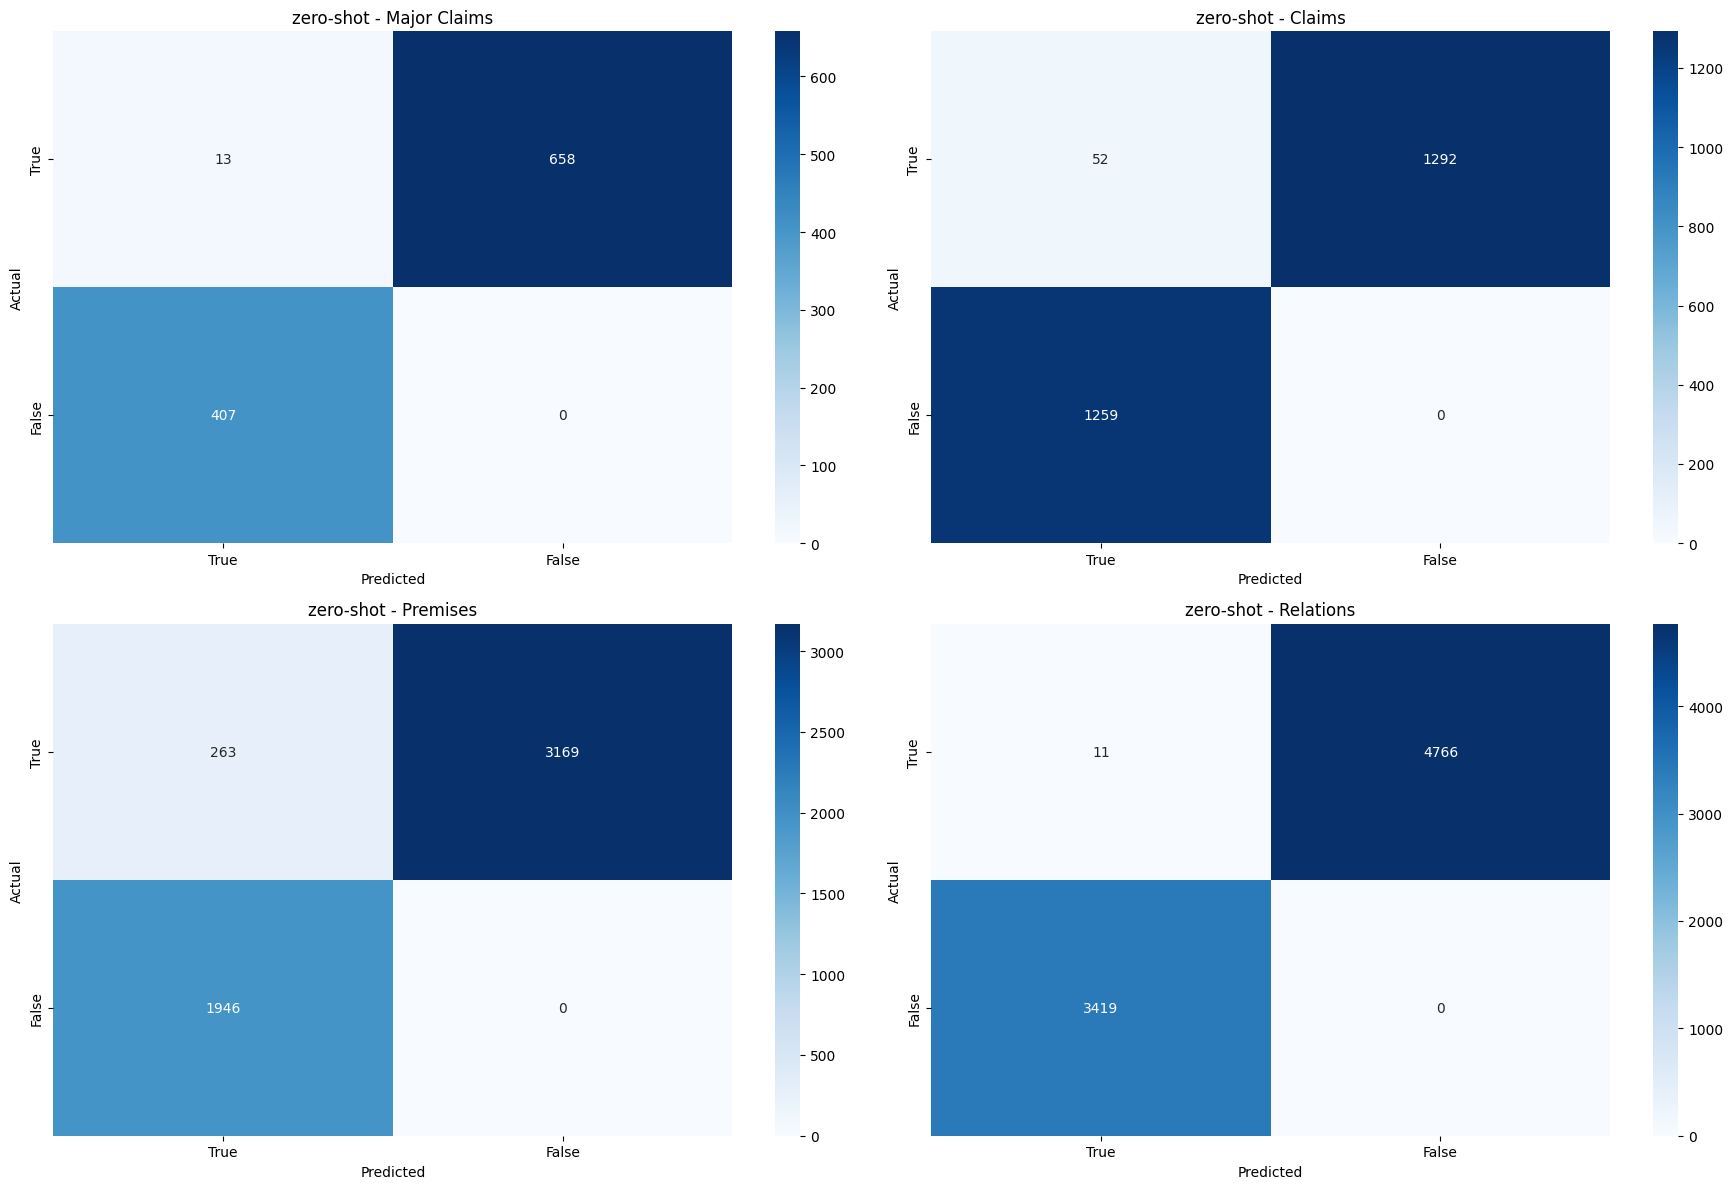

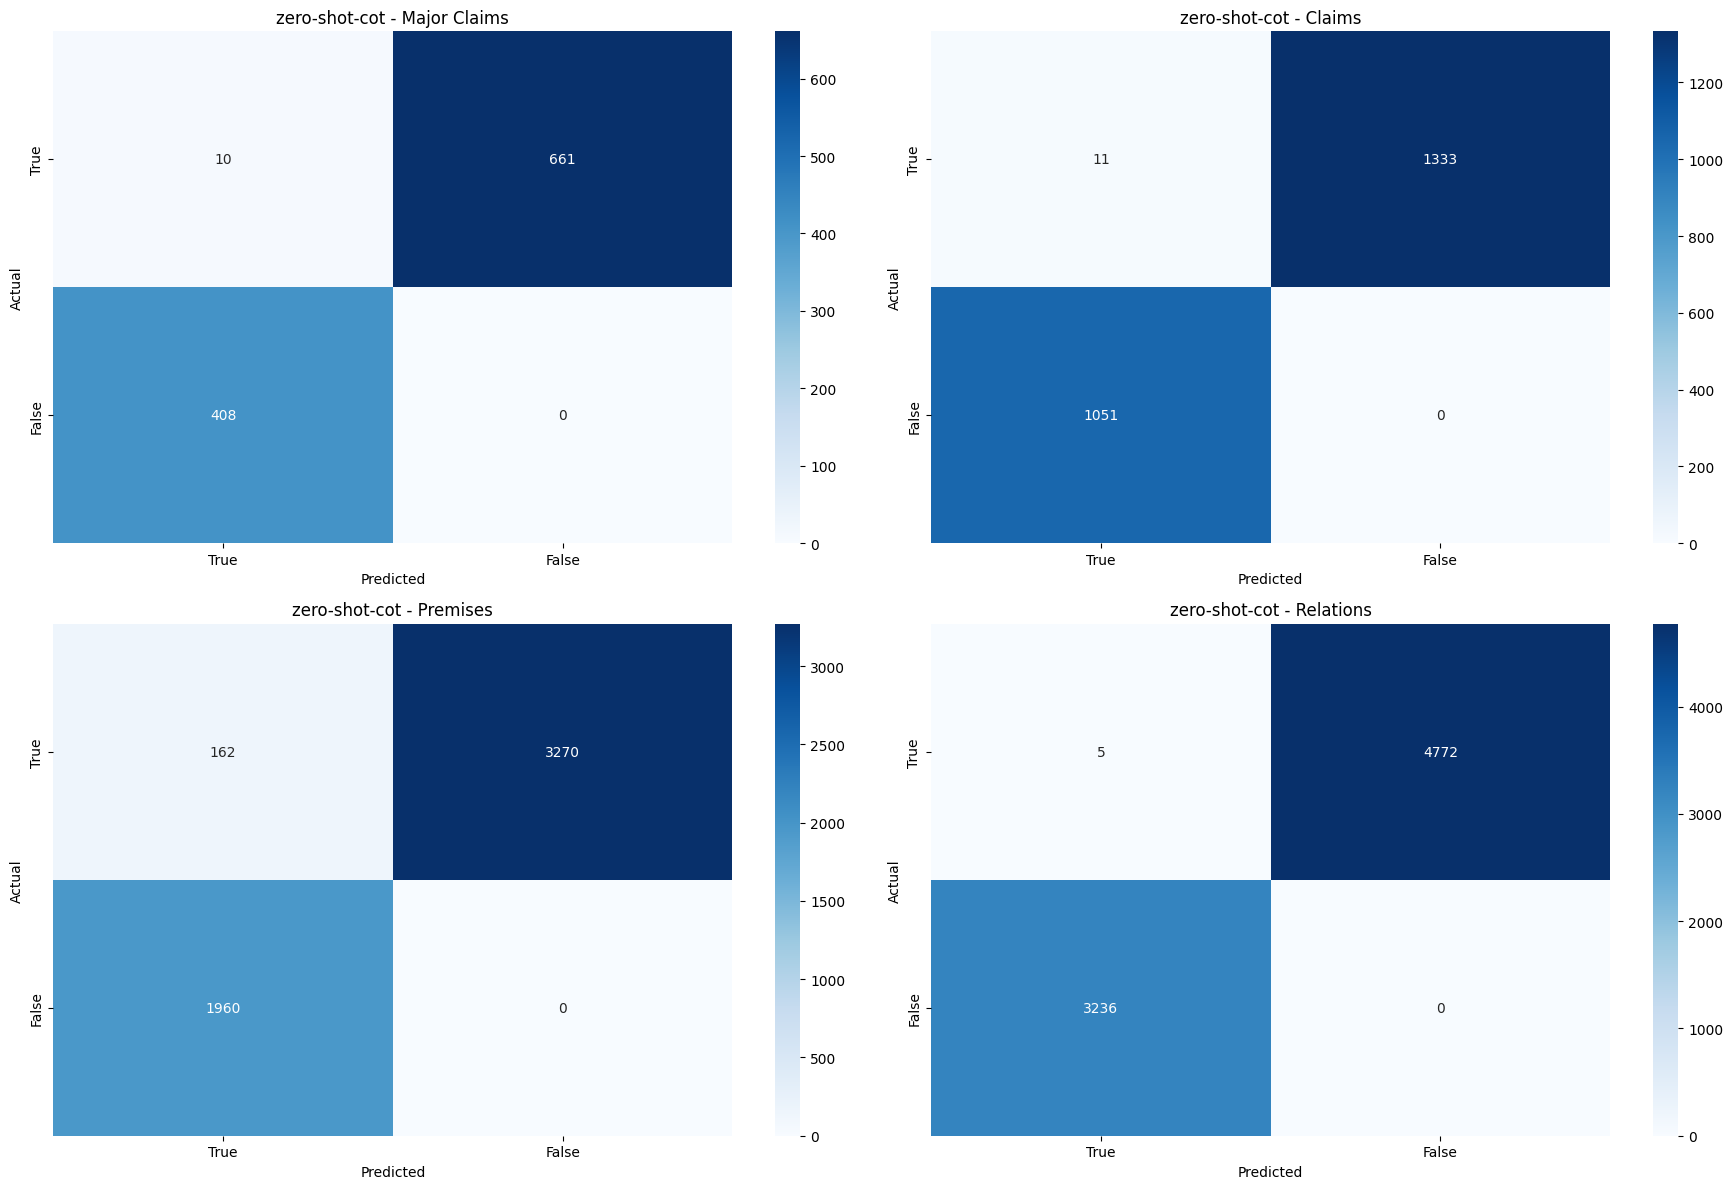

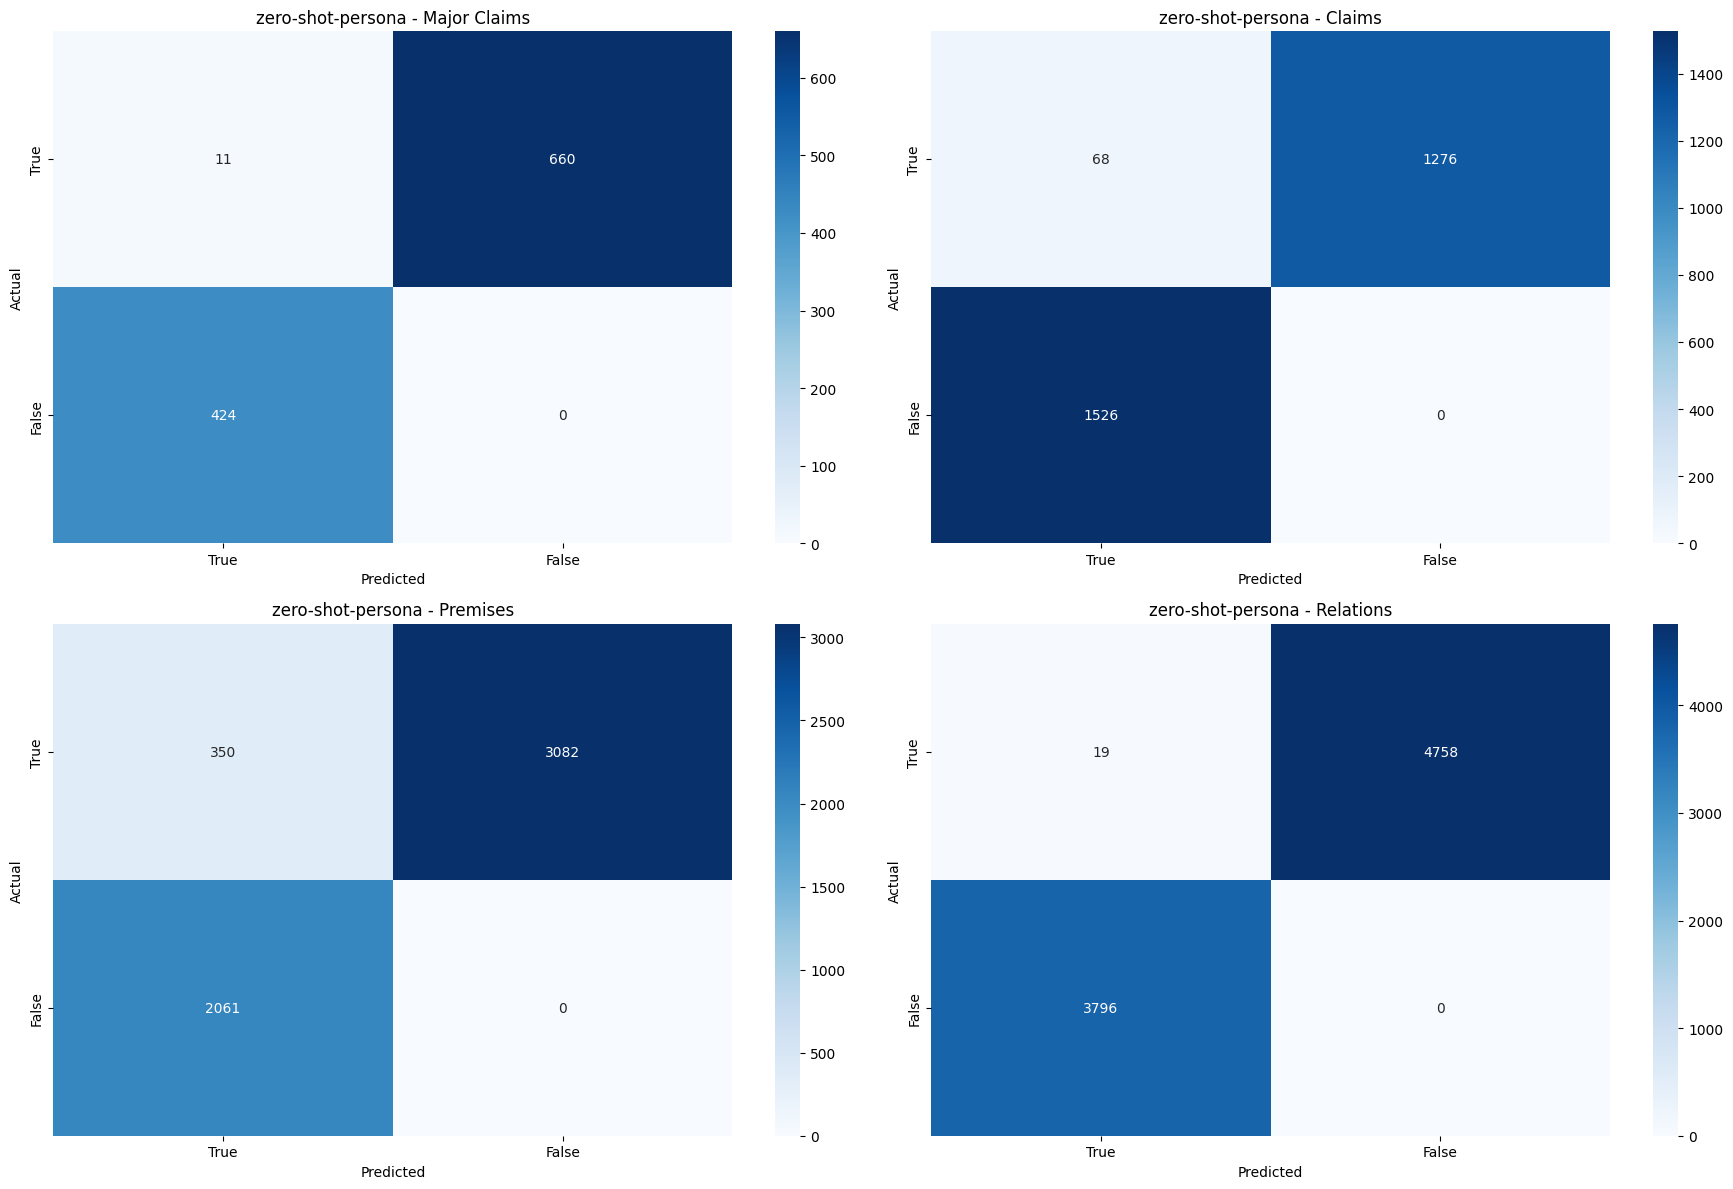

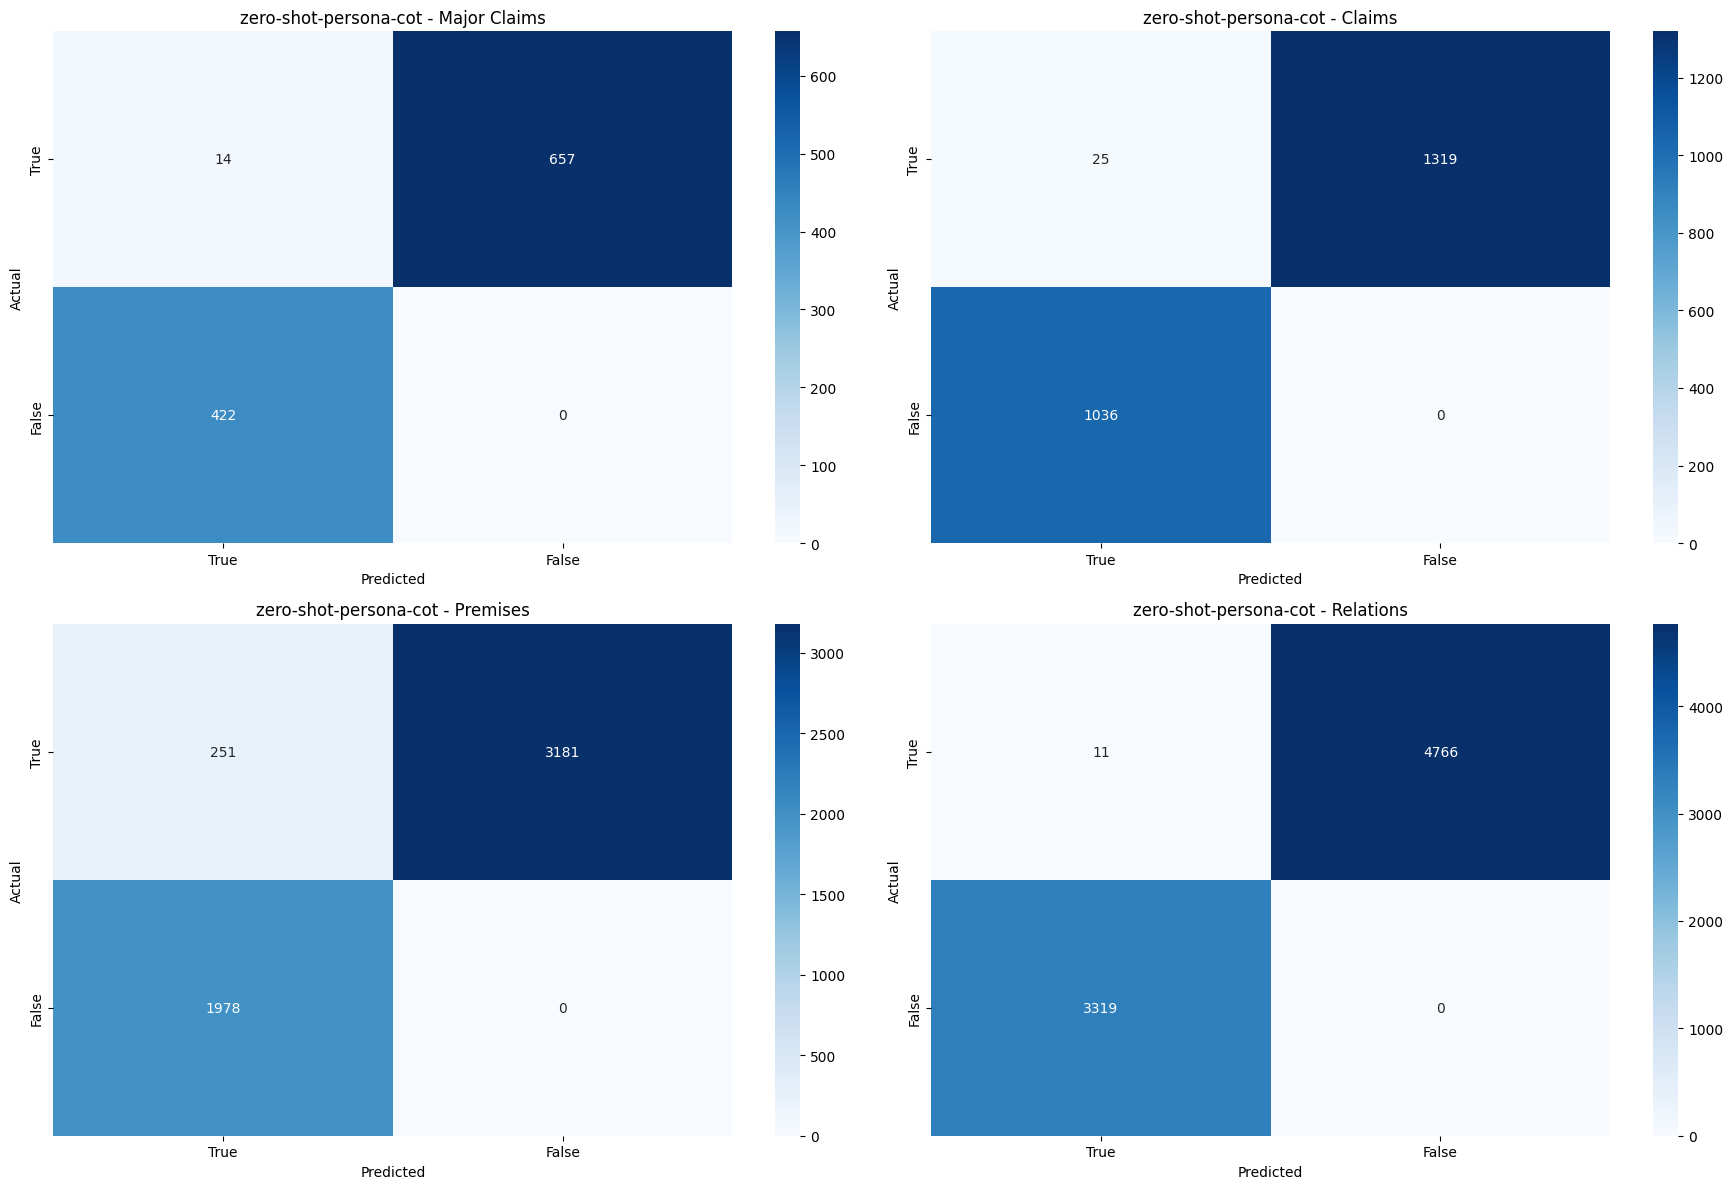

In [58]:
# Calculate the sums for each category
def calculate_confusion_matrices(zs_grouped):
    for index, row in zs_grouped.iterrows():
        total_tp_mc = row['MajorClaims_TP']
        total_fn_mc = row['MajorClaims_FN']
        total_fp_mc = row['MajorClaims_FP']
        total_tn_mc = row['MajorClaims_TN']

        total_tp_c = row['Claims_TP']
        total_fn_c = row['Claims_FN']
        total_fp_c = row['Claims_FP']
        total_tn_c = row['Claims_TN']

        total_tp_p = row['Premises_TP']
        total_fn_p = row['Premises_FN']
        total_fp_p = row['Premises_FP']
        total_tn_p = row['Premises_TN']

        total_tp_r = row['Relations_TP']
        total_fn_r = row['Relations_FN']
        total_fp_r = row['Relations_FP']
        total_tn_r = row['Relations_TN']

        # Create confusion matrices
        confusion_matrix_mc = [[total_tp_mc, total_fn_mc], [total_fp_mc, total_tn_mc]]
        confusion_matrix_c = [[total_tp_c, total_fn_c], [total_fp_c, total_tn_c]]
        confusion_matrix_p = [[total_tp_p, total_fn_p], [total_fp_p, total_tn_p]]
        confusion_matrix_r = [[total_tp_r, total_fn_r], [total_fp_r, total_tn_r]]

        # Plot confusion matrices
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))

        sns.heatmap(confusion_matrix_mc, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
        axes[0, 0].set_title(f'{index} - Major Claims')
        axes[0, 0].set_xlabel('Predicted')
        axes[0, 0].set_ylabel('Actual')
        axes[0, 0].set_xticklabels(['True', 'False'])
        axes[0, 0].set_yticklabels(['True', 'False'])

        sns.heatmap(confusion_matrix_c, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
        axes[0, 1].set_title(f'{index} - Claims')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')
        axes[0, 1].set_xticklabels(['True', 'False'])
        axes[0, 1].set_yticklabels(['True', 'False'])

        sns.heatmap(confusion_matrix_p, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
        axes[1, 0].set_title(f'{index} - Premises')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Actual')
        axes[1, 0].set_xticklabels(['True', 'False'])
        axes[1, 0].set_yticklabels(['True', 'False'])

        sns.heatmap(confusion_matrix_r, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
        axes[1, 1].set_title(f'{index} - Relations')
        axes[1, 1].set_xlabel('Predicted')
        axes[1, 1].set_ylabel('Actual')
        axes[1, 1].set_xticklabels(['True', 'False'])
        axes[1, 1].set_yticklabels(['True', 'False'])

        plt.tight_layout()
        plt.show()

# Call the function
calculate_confusion_matrices(zs_grouped)

# total_fn_mc = zs_merged_df['MajorClaims_FN'].sum()
# total_fp_mc = zs_merged_df['MajorClaims_FP'].sum()
# total_tn_mc = zs_merged_df['MajorClaims_TN'].sum()

# total_tp_c = zs_merged_df['Claims_TP'].sum()
# total_fn_c = zs_merged_df['Claims_FN'].sum()
# total_fp_c = zs_merged_df['Claims_FP'].sum()
# total_tn_c = zs_merged_df['Claims_TN'].sum()

# total_tp_p = zs_merged_df['Premises_TP'].sum()
# total_fn_p = zs_merged_df['Premises_FN'].sum()
# total_fp_p = zs_merged_df['Premises_FP'].sum()
# total_tn_p = zs_merged_df['Premises_TN'].sum()

# total_tp_r = zs_merged_df['Relations_TP'].sum()
# total_fn_r = zs_merged_df['Relations_FN'].sum()
# total_fp_r = zs_merged_df['Relations_FP'].sum()
# total_tn_r = zs_merged_df['Relations_TN'].sum()

# # Create confusion matrices
# confusion_matrix_mc = [[total_tp_mc, total_fn_mc], [total_fp_mc, total_tn_mc]]
# confusion_matrix_c = [[total_tp_c, total_fn_c], [total_fp_c, total_tn_c]]
# confusion_matrix_p = [[total_tp_p, total_fn_p], [total_fp_p, total_tn_p]]
# confusion_matrix_r = [[total_tp_r, total_fn_r], [total_fp_r, total_tn_r]]

# # Plot confusion matrices
# fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# sns.heatmap(confusion_matrix_mc, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
# axes[0, 0].set_title('Confusion Matrix for Major Claims')
# axes[0, 0].set_xlabel('Predicted')
# axes[0, 0].set_ylabel('Actual')
# axes[0, 0].set_xticklabels(['True', 'False'])
# axes[0, 0].set_yticklabels(['True', 'False'])

# sns.heatmap(confusion_matrix_c, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
# axes[0, 1].set_title('Confusion Matrix for Claims')
# axes[0, 1].set_xlabel('Predicted')
# axes[0, 1].set_ylabel('Actual')
# axes[0, 1].set_xticklabels(['True', 'False'])
# axes[0, 1].set_yticklabels(['True', 'False'])

# sns.heatmap(confusion_matrix_p, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
# axes[1, 0].set_title('Confusion Matrix for Premises')
# axes[1, 0].set_xlabel('Predicted')
# axes[1, 0].set_ylabel('Actual')
# axes[1, 0].set_xticklabels(['True', 'False'])
# axes[1, 0].set_yticklabels(['True', 'False'])

# sns.heatmap(confusion_matrix_r, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
# axes[1, 1].set_title('Confusion Matrix for Relations')
# axes[1, 1].set_xlabel('Predicted')
# axes[1, 1].set_ylabel('Actual')
# axes[1, 1].set_xticklabels(['True', 'False'])
# axes[1, 1].set_yticklabels(['True', 'False'])

# plt.tight_layout()
# plt.show()

In [59]:
count_major_claims_truth = len(zs_merged_df['major_claims_truth'].values[0])
count_major_claims_zs = len(zs_merged_df['major_claims_zs'].values[0])
count_claims_truth = len(zs_merged_df['claims_truth'].values[0])
count_claims_zs = len(zs_merged_df['claims_zs'].values[0])
count_premises_truth = len(zs_merged_df['premises_truth'].values[0])
count_premises_zs = len(zs_merged_df['premises_zs'].values[0])
count_relations_truth = len(zs_merged_df['relations_truth'].values[0])
count_relations_zs = len(zs_merged_df['relations_zs'].values[0])

print(f"Major Claims (Ground Truth): {count_major_claims_truth} + Major Claims (Output): {count_major_claims_zs} = {count_major_claims_truth + count_major_claims_zs}")
print(f"Claims (Ground Truth): {count_claims_truth} + Claims (Output): {count_claims_zs} = {count_claims_truth + count_claims_zs}")
print(f"Premises (Ground Truth): {count_premises_truth} + Premises (Output): {count_premises_zs} = {count_premises_truth + count_premises_zs}")
print(f"Relations (Ground Truth): {count_relations_truth} + Relations (Output): {count_relations_zs} = {count_relations_truth + count_relations_zs}")

Major Claims (Ground Truth): 2 + Major Claims (Output): 1 = 3
Claims (Ground Truth): 3 + Claims (Output): 3 = 6
Premises (Ground Truth): 6 + Premises (Output): 5 = 11
Relations (Ground Truth): 9 + Relations (Output): 8 = 17


In [60]:
# Calculate precision, recall, and f1-score for MajorClaims
# Für den Fall, dass der Nenner 0 ist, wird der Wert auf 0 gesetzt, um eine Division durch 0 und somit eine Fehlermeldung zu vermeiden.
precision_mc = round(total_tp_mc / (total_tp_mc + total_fp_mc), 2) if (total_tp_mc + total_fp_mc) != 0 else 0 
recall_mc = round(total_tp_mc / (total_tp_mc + total_fn_mc), 2) if (total_tp_mc + total_fn_mc) != 0 else 0
f1_score_mc = round(2 * (precision_mc * recall_mc) / (precision_mc + recall_mc), 2) if (precision_mc + recall_mc) != 0 else 0

# Calculate precision, recall, and f1-score for Claims
precision_c = round(total_tp_c / (total_tp_c + total_fp_c), 2) if (total_tp_c + total_fp_c) != 0 else 0
recall_c = round(total_tp_c / (total_tp_c + total_fn_c), 2) if (total_tp_c + total_fn_c) != 0 else 0
f1_score_c = round(2 * (precision_c * recall_c) / (precision_c + recall_c), 2) if (precision_c + recall_c) != 0 else 0

# Calculate precision, recall, and f1-score for Premises
precision_p = round(total_tp_p / (total_tp_p + total_fp_p), 2) if (total_tp_p + total_fp_p) != 0 else 0
recall_p = round(total_tp_p / (total_tp_p + total_fn_p), 2) if (total_tp_p + total_fn_p) != 0 else 0
f1_score_p = round(2 * (precision_p * recall_p) / (precision_p + recall_p), 2) if (precision_p + recall_p) != 0 else 0

# Calculate precision, recall, and f1-score for Relations
precision_r = round(total_tp_r / (total_tp_r + total_fp_r), 2) if (total_tp_r + total_fp_r) != 0 else 0
recall_r = round(total_tp_r / (total_tp_r + total_fn_r), 2) if (total_tp_r + total_fn_r) != 0 else 0
f1_score_r = round(2 * (precision_r * recall_r) / (precision_r + recall_r), 2) if (precision_r + recall_r) != 0 else 0

# Create a DataFrame with the evaluation metrics
evaluation_metrics = pd.DataFrame([
    {'Category': 'Major Claims', 'Precision': precision_mc, 'Recall': recall_mc, 'F1-Score': f1_score_mc},
    {'Category': 'Claims', 'Precision': precision_c, 'Recall': recall_c, 'F1-Score': f1_score_c},
    {'Category': 'Premises', 'Precision': precision_p, 'Recall': recall_p, 'F1-Score': f1_score_p},
    {'Category': 'Relations', 'Precision': precision_r, 'Recall': recall_r, 'F1-Score': f1_score_r}
])
evaluation_metrics

,Category,Precision,Recall,F1-Score
0,Major Claims,0.00,0.00,0.00
1,Claims,0.00,0.00,0.00
2,Premises,0.30,0.27,0.28
3,Relations,0.05,0.04,0.04
